In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split


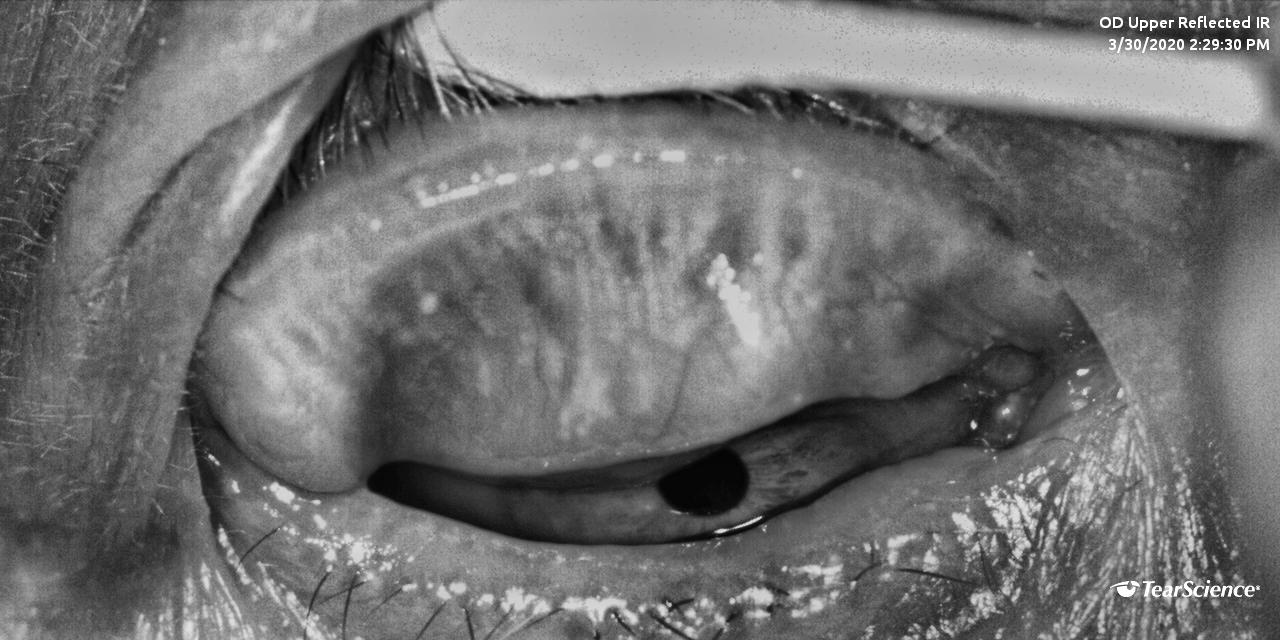

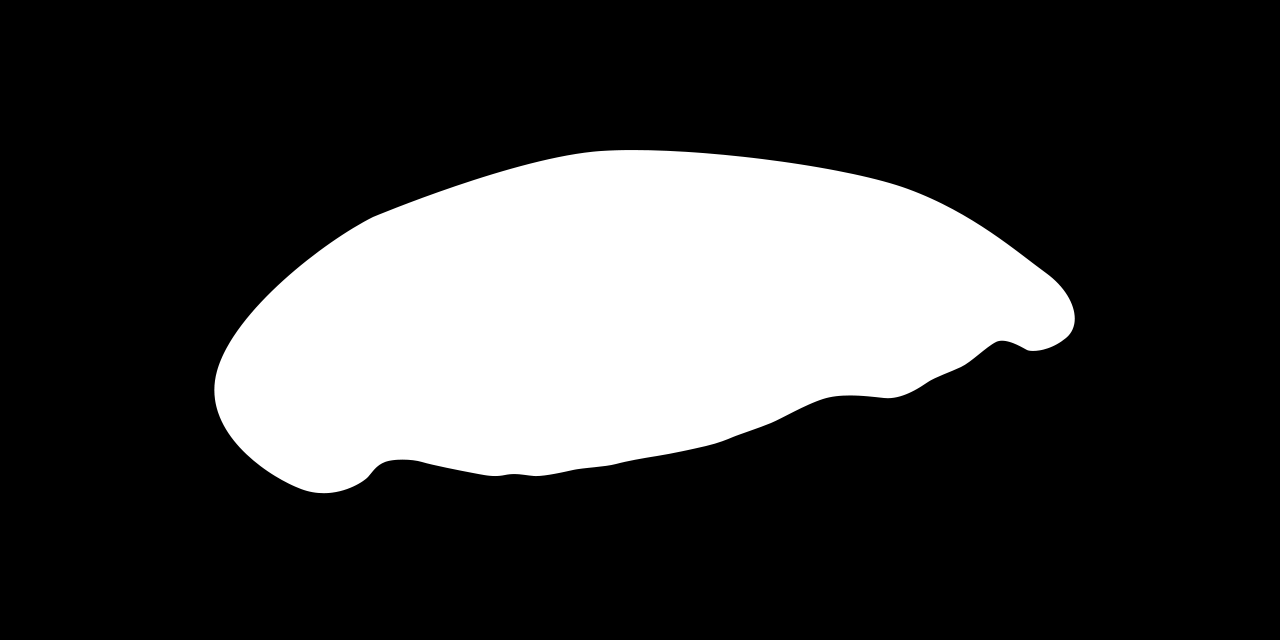

In [ ]:
import os
from glob import glob
import cv2
from google.colab.patches import cv2_imshow

if __name__ == "__main__":
    """ Load the dataset """
    train_img_path = "../content/drive/MyDrive/Deeplab/train/images"
    train_mask_path = "../content/drive/MyDrive/Deeplab/train/masks"

    # Load sample image and mask
    train_image_path = os.path.join(train_img_path, "DMI_OD_UPPER_REFLECTED_IR_10209332.JPG")
    train_image = cv2.imread(train_image_path)

    # Check if image loaded correctly
    if train_image is None:
        print("Error loading image:", train_image_path)
        exit(1)

    train_mask = cv2.imread(os.path.join(train_mask_path, "DMI_OD_UPPER_REFLECTED_IR_10209332.png"))

    # Print sample images
    cv2_imshow(train_image)

    # Print sample masks
    cv2_imshow(train_mask)

    cv2.waitKey(0)  # Wait for key press to close windows


In [ ]:
#Model
from tensorflow.keras.applications import ResNet101
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
from tensorflow.keras.models import Model

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense


def squeeze_excite(inputs, ratio=8):
    init = inputs
    filters = init.shape[-1]
    sq_ex_shape = (1, 1, filters)

    seb = GlobalAveragePooling2D()(init)
    seb = Reshape(sq_ex_shape)(seb)
    seb = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(seb)
    seb = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(seb)
    x = init * seb
    return x

def ASPP(inputs):
    """ Image Pooling """
    shape = inputs.shape
    avg_pooled = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    ang_pooled = Conv2D(128, 1, padding="same", use_bias=False)(avg_pooled)
    avg_pooled = BatchNormalization()(avg_pooled)
    avg_pooled = Activation("relu")(avg_pooled)
    avg_pooled = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(avg_pooled)

    """ 1x1 conv """
    conv_1 = Conv2D(128, 1, padding="same", use_bias=False)(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)

    """ 3x3 conv rate=6 """
    conv_dil6 = Conv2D(128, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    conv_dil6 = BatchNormalization()(conv_dil6)
    conv_dil6 = Activation("relu")(conv_dil6)

    """ 3x3 conv rate=12 """
    conv_dil12 = Conv2D(128, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
    conv_dil12 = BatchNormalization()(conv_dil12)
    conv_dil12 = Activation("relu")(conv_dil12)

    """ 3x3 conv rate=18 """
    conv_dil18 = Conv2D(128, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    conv_dil18 = BatchNormalization()(conv_dil18)
    conv_dil18 = Activation("relu")(conv_dil18)

    y = Concatenate()([avg_pooled, conv_1, conv_dil6, conv_dil12, conv_dil18])
    y = Conv2D(128, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def deeplabv3_plus(shape):
    """ Input """
    inputs = Input(shape)

    """ Encoder """
    enc = ResNet101(weights="imagenet", include_top=False, input_tensor=inputs)

    image_features = enc.get_layer("conv4_block6_out").output
    aspp_out = ASPP(image_features)
    aspp_upsampled = UpSampling2D((4, 4), interpolation="bilinear")(aspp_out)

    conv2_out = enc.get_layer("conv2_block2_out").output
    conv2_filtered = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(conv2_out)
    conv2_normalized = BatchNormalization()(conv2_filtered)
    conv2_relu = Activation('relu')(conv2_normalized)

    concate_features = Concatenate()([aspp_upsampled, conv2_relu])
    excite_out = squeeze_excite(concate_features)

    conv3_out = Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False)(excite_out)
    conv3_normalized = BatchNormalization()(conv3_out)
    conv3_relu = Activation('relu')(conv3_normalized)

    conv4_out = Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False)(conv3_relu)
    conv4_normalized = BatchNormalization()(conv4_out)
    conv4_relu = Activation('relu')(conv4_normalized)
    conv4_excited = squeeze_excite(conv4_relu)

    final_upsampled = UpSampling2D((4, 4), interpolation="bilinear")(conv4_excited)
    final_conv = Conv2D(1, 1)(final_upsampled)
    final_out = Activation("sigmoid")(final_conv)

    model = Model(inputs, final_out)
    return model

if __name__ == "__main__":
    model = deeplabv3_plus((640, 1280, 3))

In [ ]:
#RESTNET 101

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"

import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, Accuracy

from tensorflow.keras.layers import Input

def int_over_union(y_true, y_pred):
    def calculate_iou(y_true, y_pred):
        intersec = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersec
        iou_value = (intersec + 1e-15) / (union + 1e-15)
        iou_value = iou_value.astype(np.float32)
        return iou_value
    return tf.numpy_function(calculate_iou, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coefficient(y_true, y_pred):
    y_true_flat = tf.keras.layers.Flatten()(y_true)
    y_pred_flat = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

""" Global parameters """
height = 640
width = 1280
data_path = "../content/drive/MyDrive/Deeplab"
model_path = os.path.join("files_Deep", "model.h5")
csv_path = os.path.join("files_Deep", "data.csv")


""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

create_dir("files_Deep")

def load_data(path):
    x = sorted(glob(os.path.join(path, "images", "*JPG")))
    y = sorted(glob(os.path.join(path, "masks", "*png")))
    return x, y

def read_img(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_img(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])
    return x, y

def tf_ds(X, Y, batch=2, shuffle_buffer_size=1000, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    if augment:
        # Data augmentation parameters
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=90,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='reflect'
        )

        # Apply data augmentation to the training set
        ds = ds.map(lambda x, y: (datagen.random_transform(x) if len(x.shape) == 3 else x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    ds = ds.map(tf_parse)
    ds = ds.batch(batch)
    ds = ds.prefetch(10)
    return ds


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(45)
    tf.random.set_seed(45)

    """ Hyperparameters """
    batch_size = 2
    initial_lr = 1e-6
    num_epochs = 10

    """ Dataset """
    data_path = "../content/drive/MyDrive/Deeplab"

    train_path = os.path.join(data_path, "train")
    valid_path = os.path.join(data_path, "test")

    train_x, train_y = load_data(train_path)
    valid_x, valid_y = load_data(valid_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"valid: {len(valid_x)} - {len(valid_y)}")

    # Create datasets with and without data augmentation
    train_ds = tf_ds(train_x, train_y, batch=batch_size, augment=True)
    valid_ds = tf_ds(valid_x, valid_y, batch=batch_size)

    # Assuming deeplabv3_plus is a function that returns a Keras model
    model = deeplabv3_plus((height, width, 3))
    optimizer = Adam(learning_rate=initial_lr)
    model.compile(loss=dice_loss, optimizer=optimizer, metrics=[dice_coefficient, int_over_union, Recall(), Precision(), Accuracy()])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=False),
    ]

    model.fit(
        train_ds,
        epochs=num_epochs,
        validation_data=valid_ds,
        callbacks=callbacks
    )


Train: 500 - 500
valid: 50 - 50
Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: -0.3340 - dice_coefficient: 1.3340 - int_over_union: 2.0833 - recall: 0.9450 - precision: 0.2186 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.99962, saving model to files_Deep/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 537s 2s/step - loss: -0.3340 - dice_coefficient: 1.3340 - int_over_union: 2.0833 - recall: 0.9450 - precision: 0.2186 - accuracy: 0.0000e+00 - val_loss: 0.9996 - val_dice_coefficient: 3.7555e-04 - val_int_over_union: 1.8794e-04 - val_recall: 1.2692e-04 - val_precision: 0.0065 - val_accuracy: 2.9250e-04 - lr: 1.0000e-06
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: -0.6089 - dice_coefficient: 1.6089 - int_over_union: 4.2930 - recall: 0.9840 - precision: 0.2898 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 0.99962 to 0.54290, saving model to files_Deep/model.h5
250/250 [==============================] - 113s 454ms/step - loss: -0.6089 - dice_coefficient: 1.6089 - int_over_union: 4.2930 - recall: 0.9840 - precision: 0.2898 - accuracy: 0.0000e+00 - val_loss: 0.5429 - val_dice_coefficient: 0.4571 - val_int_over_union: 0.3916 - val_recall: 0.2229 - val_precision: 0.2202 - val_accuracy: 0.0058 - lr: 1.0000e-06
Epoch 3

In [ ]:
import numpy as np
import os
import pandas as pd
from glob import glob
import cv2
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tqdm import tqdm

# custom metric functions
def int_over_union(y_true, y_pred):
    def calculate_iou(y_true, y_pred):
        intersec = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersec
        iou_value = (intersec + 1e-15) / (union + 1e-15)
        iou_value = iou_value.astype(np.float32)
        return iou_value
    return tf.numpy_function(calculate_iou, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coefficient(y_true, y_pred):
    y_true_flat = tf.keras.layers.Flatten()(y_true)
    y_pred_flat = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

# Load the model with custom metric functions
model_path = "../content/files_Deep/model.h5"
with CustomObjectScope({
    "iou": int_over_union,
    "dice_coefficient": dice_coefficient,
    "dice_loss": dice_loss
}):
    model = tf.keras.models.load_model(model_path)




In [ ]:
import numpy as np
import os
import pandas as pd
from glob import glob
import cv2
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tqdm import tqdm

#custom metric functions
def int_over_union(y_true, y_pred):
    def calculate_iou(y_true, y_pred):
        intersec = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersec
        iou_value = (intersec + 1e-15) / (union + 1e-15)
        iou_value = iou_value.astype(np.float32)
        return iou_value
    return tf.numpy_function(calculate_iou, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coefficient(y_true, y_pred):
    y_true_flat = tf.keras.layers.Flatten()(y_true)
    y_pred_flat = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

# utility functions
def load_data(path):
    x = sorted(glob(os.path.join(path, "images", "*JPG")))
    y = sorted(glob(os.path.join(path, "masks", "*png")))
    return x, y

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_results(img, mask, y_pr, save_img_path):
    sep = np.ones((height, width, 3)) * 128

    # Ensure y_pr has the same shape as img
    if y_pr.shape[-1] == 1:
        y_pr = np.squeeze(y_pr, axis=-1)

    mask = np.expand_dims(mask, axis=2)  # Add a channel dimension
    mask = np.concatenate([mask, mask, mask], axis=-1)
    mask = mask * 255

    y_pr = np.expand_dims(y_pr, axis=2)  # Add a channel dimension
    y_pr = np.concatenate([y_pr, y_pr, y_pr], axis=-1)
    y_pr = y_pr * 255

    masked_img = img * y_pr
    eye_img = np.concatenate([img, sep, mask, sep, y_pr, masked_img], axis=1)
    cv2.imwrite(save_img_path, eye_img)

# Global parameters
height = 640
width = 1280
data_path = "../content/drive/MyDrive/Deeplab"

# Create result directory
result_path = os.path.join(data_path, "deeplabRes", "result")
create_dir(result_path)

# Load the model with custom metric functions
model_path = "../content/files_Deep/model.h5"
custom_objects = {
    'int_over_union': int_over_union,
    'dice_coefficient': dice_coefficient,
    'dice_loss': dice_loss
}

model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# Load the dataset
data_path = "../content/drive/MyDrive/Deeplab"
valid_path = os.path.join(data_path, "test")
test_x, test_y = load_data(valid_path)
print(f"Test: {len(test_x)}")

# Prediction and evaluation
SCORE = []  # Initialize SCORE list

for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    name = x.split("/")[-1].split(".")[0]

    # Image read
    img = cv2.imread(x, cv2.IMREAD_COLOR)
    x = img / 255.0
    x = np.expand_dims(x, axis=0)

    # Read mask
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

    # Prediction
    y_pr = model.predict(x)[0]
    y_pr = np.squeeze(y_pr, axis=-1)
    y_pr = y_pr > 0.5
    y_pr = y_pr.astype(np.int32)

    # Save result
    save_img_path = os.path.join(result_path, f"{name}.png")
    save_results(img, mask, y_pr, save_img_path)

    # Flatten the arrays
    mask_flat = mask.flatten()
    y_pr_flat = y_pr.flatten()


 # Calculate metrics

    acc_value = accuracy_score(mask_flat, y_pr_flat)
    f1_val = f1_score(mask_flat, y_pr_flat, average='weighted')  # Change average to 'weighted'
    jac_val = jaccard_score(mask_flat, y_pr_flat, labels=[0, 1], average='weighted')  # Change average to 'weighted'
    recall_val = recall_score(mask_flat, y_pr_flat, labels=[0, 1], average='weighted')  # Change average to 'weighted'
    precision_value = precision_score(mask_flat, y_pr_flat, labels=[0, 1], average='weighted')  # Change average to 'weighted'



    SCORE.append([name, acc_value, f1_val, jac_val, recall_val, precision_value])

# Metrics values
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")

# Save results to CSV
df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv(os.path.join(result_path, "score.csv"))


Test: 50


  0%|          | 0/50 [00:00<?, ?it/s]WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ea71c785c60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 1s 1s/step


  2%|▏         | 1/50 [00:01<01:26,  1.77s/it]

1/1 [==============================] - 0s 103ms/step


  4%|▍         | 2/50 [00:02<00:56,  1.18s/it]

1/1 [==============================] - 0s 102ms/step


  6%|▌         | 3/50 [00:03<00:46,  1.02it/s]

1/1 [==============================] - 0s 97ms/step


  8%|▊         | 4/50 [00:04<00:41,  1.11it/s]

1/1 [==============================] - 0s 98ms/step


 10%|█         | 5/50 [00:04<00:38,  1.18it/s]

1/1 [==============================] - 0s 102ms/step


 12%|█▏        | 6/50 [00:05<00:36,  1.22it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█▍        | 7/50 [00:06<00:35,  1.22it/s]

1/1 [==============================] - 0s 100ms/step


 16%|█▌        | 8/50 [00:07<00:33,  1.24it/s]

1/1 [==============================] - 0s 102ms/step


 18%|█▊        | 9/50 [00:07<00:32,  1.27it/s]

1/1 [==============================] - 0s 96ms/step


 20%|██        | 10/50 [00:08<00:31,  1.29it/s]

1/1 [==============================] - 0s 95ms/step


 22%|██▏       | 11/50 [00:09<00:30,  1.27it/s]

1/1 [==============================] - 0s 116ms/step


 24%|██▍       | 12/50 [00:10<00:34,  1.10it/s]

1/1 [==============================] - 0s 122ms/step


 26%|██▌       | 13/50 [00:11<00:36,  1.01it/s]

1/1 [==============================] - 0s 111ms/step


 28%|██▊       | 14/50 [00:13<00:38,  1.07s/it]

1/1 [==============================] - 0s 120ms/step


 30%|███       | 15/50 [00:14<00:39,  1.12s/it]

1/1 [==============================] - 0s 113ms/step


 32%|███▏      | 16/50 [00:15<00:39,  1.16s/it]

1/1 [==============================] - 0s 110ms/step


 34%|███▍      | 17/50 [00:16<00:35,  1.07s/it]

1/1 [==============================] - 0s 93ms/step


 36%|███▌      | 18/50 [00:17<00:31,  1.03it/s]

1/1 [==============================] - 0s 93ms/step


 38%|███▊      | 19/50 [00:17<00:28,  1.09it/s]

1/1 [==============================] - 0s 103ms/step


 40%|████      | 20/50 [00:18<00:26,  1.15it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████▏     | 21/50 [00:19<00:24,  1.19it/s]

1/1 [==============================] - 0s 97ms/step


 44%|████▍     | 22/50 [00:20<00:23,  1.21it/s]

1/1 [==============================] - 0s 97ms/step


 46%|████▌     | 23/50 [00:21<00:21,  1.24it/s]

1/1 [==============================] - 0s 102ms/step


 48%|████▊     | 24/50 [00:21<00:20,  1.26it/s]

1/1 [==============================] - 0s 101ms/step


 50%|█████     | 25/50 [00:22<00:19,  1.26it/s]

1/1 [==============================] - 0s 95ms/step


 52%|█████▏    | 26/50 [00:23<00:18,  1.27it/s]

1/1 [==============================] - 0s 95ms/step


 54%|█████▍    | 27/50 [00:24<00:18,  1.26it/s]

1/1 [==============================] - 0s 94ms/step


 56%|█████▌    | 28/50 [00:25<00:17,  1.24it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████▊    | 29/50 [00:25<00:16,  1.27it/s]

1/1 [==============================] - 0s 100ms/step


 60%|██████    | 30/50 [00:27<00:18,  1.09it/s]

1/1 [==============================] - 0s 107ms/step


 62%|██████▏   | 31/50 [00:28<00:19,  1.01s/it]

1/1 [==============================] - 0s 112ms/step


 64%|██████▍   | 32/50 [00:29<00:19,  1.07s/it]

1/1 [==============================] - 0s 107ms/step


 66%|██████▌   | 33/50 [00:30<00:18,  1.12s/it]

1/1 [==============================] - 0s 116ms/step


 68%|██████▊   | 34/50 [00:31<00:18,  1.15s/it]

1/1 [==============================] - 0s 114ms/step


 70%|███████   | 35/50 [00:32<00:15,  1.07s/it]

1/1 [==============================] - 0s 102ms/step


 72%|███████▏  | 36/50 [00:33<00:13,  1.01it/s]

1/1 [==============================] - 0s 97ms/step


 74%|███████▍  | 37/50 [00:34<00:12,  1.07it/s]

1/1 [==============================] - 0s 98ms/step


 76%|███████▌  | 38/50 [00:35<00:10,  1.13it/s]

1/1 [==============================] - 0s 99ms/step


 78%|███████▊  | 39/50 [00:35<00:09,  1.16it/s]

1/1 [==============================] - 0s 102ms/step


 80%|████████  | 40/50 [00:36<00:08,  1.17it/s]

1/1 [==============================] - 0s 102ms/step


 82%|████████▏ | 41/50 [00:37<00:07,  1.21it/s]

1/1 [==============================] - 0s 100ms/step


 84%|████████▍ | 42/50 [00:38<00:06,  1.24it/s]

1/1 [==============================] - 0s 98ms/step


 86%|████████▌ | 43/50 [00:39<00:05,  1.24it/s]

1/1 [==============================] - 0s 106ms/step


 88%|████████▊ | 44/50 [00:39<00:04,  1.26it/s]

1/1 [==============================] - 0s 107ms/step


 90%|█████████ | 45/50 [00:40<00:03,  1.25it/s]

1/1 [==============================] - 0s 99ms/step


 92%|█████████▏| 46/50 [00:41<00:03,  1.24it/s]

1/1 [==============================] - 0s 94ms/step


 94%|█████████▍| 47/50 [00:42<00:02,  1.25it/s]

1/1 [==============================] - 0s 101ms/step


 96%|█████████▌| 48/50 [00:43<00:01,  1.08it/s]

1/1 [==============================] - 0s 128ms/step


 98%|█████████▊| 49/50 [00:44<00:01,  1.01s/it]

1/1 [==============================] - 0s 114ms/step


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]

Accuracy: 0.00207
F1: 0.00404
Jaccard: 0.00256
Recall: 0.00261
Precision: 0.99995
